# Segmentation map으로 도로 이미지 만들기
---

이번 프로젝트에서는 Pix2Pix 이미지 변환 모델을 구현해보겠다. 라벨이 되는 도로 이미지에 segmentation정보(Input)가 담겨있으며 Unet Generator모델에서 이를 참고해 가짜 이미지를 생성한다. Discriminator 모델은 실제 이미지(Ground truth)와 segmentation 이미지, 생성자가 생성한 이미지를 가지고 판별을 하게된다. 




![d](https://www.secmem.org/assets/images/pix2pix/result1.PNG)


In [1]:
import numpy
import tensorflow
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt

### 이미지 데이터
- [cityscapes.zip](https://d3s0tskafalll9.cloudfront.net/media/documents/cityscapes.zip)
 - 학습용 이미지 : 1000개 (사이즈 : 256, 512, 3)
 - 평가 이미지 : 5개


In [2]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/Aiffel/02_Exploration/exp17/data/cityscapes.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Aiffel/02_Exploration/exp17/data/cityscapes.zip
replace cityscapes/train/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: nA
replace cityscapes/train/100.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

number of train examples : 1000


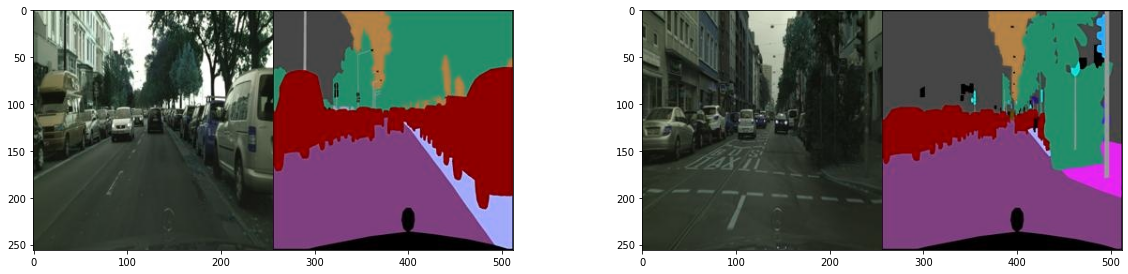

In [3]:
data_path = '/content/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

plt.figure(figsize=(20,15))
for i in range(1, 3):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
#이미지 사이즈 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


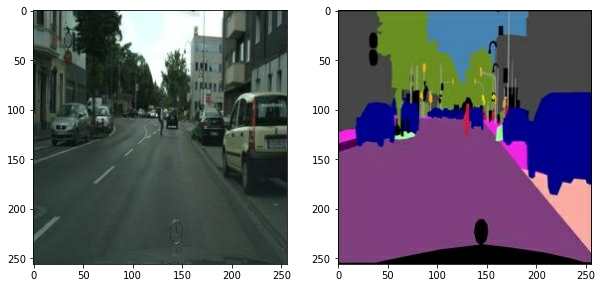

In [5]:
# 이미지 분할
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

### Image Augmentation
 - 훈련용 이미지에 증강적용



In [6]:
from tensorflow import image

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    #sketch:앞 3채널, colored:뒤 3채널
    return out[...,:3], out[...,3:]  

### 데이터셋 구성
- 이미지 증강한 데이터셋과 아닌 데이터넷의 학습 성능비교를 위해 두가지 데이터셋을 설정하여 실험을 진행해보겠다.

In [7]:
from tensorflow import data

def get_train_org(img_path):
    sketch, colored = load_img(img_path)
    return sketch, colored

def get_train_aug(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)    
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images_org = train_images.map(get_train_org).shuffle(100).batch(4)
train_images_aug = train_images.map(get_train_aug).shuffle(100).batch(4)

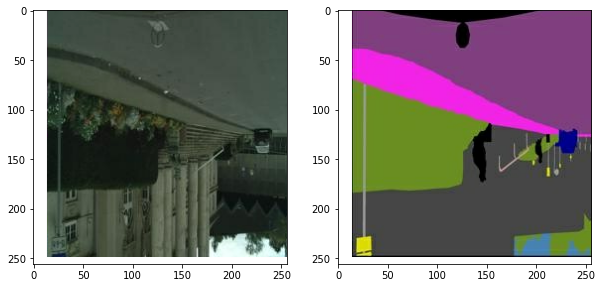

In [8]:
# augmentation sample 확인
sample = train_images_aug.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

pix2pix 모델
---

### Generator

- EncodeBlock(Downsampling Block)
- DecodeBlock(Upsampling Block)
- UNetGenerator

### Discriminator 
- DiscBlock
- Discriminator
 - 70x70 PatchGAN을 사용
 

In [9]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()


In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block (EncodeBlock)     (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_1 (EncodeBlock)   (None, 64, 64, 128)  131584      ['encode_block[0][0]']           
                                                                                              

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']          






- U-Net generator, discriminator 모델 구현이 완료되어 train_step이 안정적으로 진행

손실함수 및 옵티마이저 정의
---


In [14]:
from tensorflow.keras import losses
from tensorflow.keras import optimizers

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [15]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

학습 및 테스트하기
---

10 epoch 이상의 학습을 진행한 후 최종 테스트 결과에서 진행한 epoch 수에 걸맞은 정도의 품질

In [16]:
generator = UNetGenerator()
discriminator = Discriminator()

def train_unet(train_images, EPOCHS):
    #시각화 데이터 설정
    history = {'g_loss': [], 'l1_loss': [], 'd_loss': [] }

    for epoch in range(1, EPOCHS+1):
        for i, (sketch, colored) in enumerate(train_images):
            g_loss, l1_loss, d_loss = train_step(sketch, colored)
                    
            # 10회 반복마다 손실을 출력합니다.
            if (i+1) % 10 == 0:
                ##시각화 정보 설정
                history['g_loss'].append(g_loss.numpy())
                history['l1_loss'].append(l1_loss.numpy())
                history['d_loss'].append(d_loss.numpy())

                print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                        \tGenerator_loss:{g_loss.numpy():.4f} \
                        \tL1_loss:{l1_loss.numpy():.4f} \
                        \tDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
                
    return history

In [18]:
history_aug = train_unet(train_images_aug, 10)

EPOCH[1] - STEP[10]                         	Generator_loss:0.8259                         	L1_loss:0.3125                         	Discriminator_loss:1.2743

EPOCH[1] - STEP[20]                         	Generator_loss:0.8742                         	L1_loss:0.2607                         	Discriminator_loss:1.1387

EPOCH[1] - STEP[30]                         	Generator_loss:1.1380                         	L1_loss:0.2844                         	Discriminator_loss:1.0669

EPOCH[1] - STEP[40]                         	Generator_loss:1.0253                         	L1_loss:0.2528                         	Discriminator_loss:1.2175

EPOCH[1] - STEP[50]                         	Generator_loss:1.4046                         	L1_loss:0.2218                         	Discriminator_loss:0.8910

EPOCH[1] - STEP[60]                         	Generator_loss:1.5101                         	L1_loss:0.2186                         	Discriminator_loss:0.6666

EPOCH[1] - STEP[70]                         	G

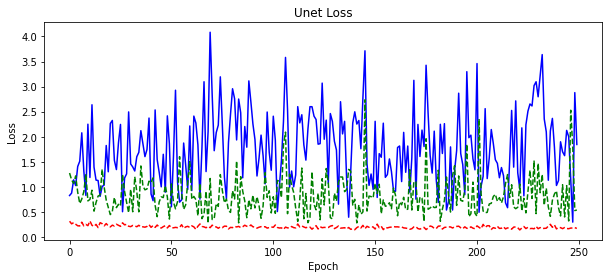

In [28]:
def show_history(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history['g_loss'], 'b-', label='Generator loss')
    plt.plot(history['l1_loss'], 'r--', label='L1 loss')
    plt.plot(history['d_loss'], 'g--', label='Discriminator loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Unet Loss')
   
    plt.show()

show_history(history_aug)

epoch 10회 동안 생성자의 손실값 범위가 편별자의 손실값 범위보다 높다. epoch이 진행됨에 따라 생성자의 성능이 좋은지는 더 테스트 해보아야할 것 같다.

그리고 이미지셋에 증강을 적용한것과 적용하지 않는 경우에 대해 훈련을 진행했을때 epoch 10회에 대한 로스값은 큰차이는 없었다. 아래의 그래프와 표를 통해 확인할 수 있다. 이미지 증강의 효과또한 epoch에 따라 달라지는지 체크해볼 부분인것 같다.

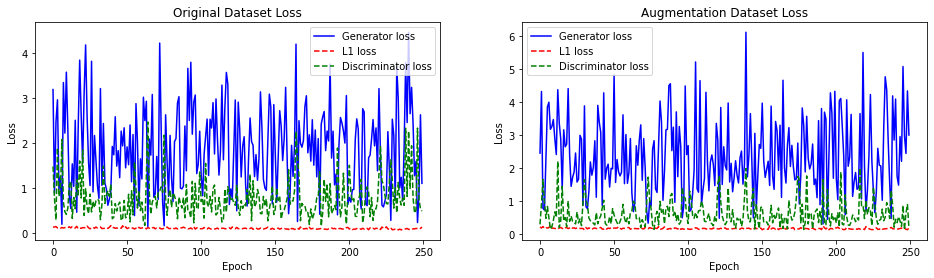

In [37]:
#show_history(history_org, history_aug )

데이터셋에따라 epoch 10회에 대한 최종 loss를 알아보면 아래와 같다.

|데이터셋|Generator loss|L1 loss|Disciminator loss|
|:---|:---|---|---|
|ep  10 - Original Image Dataset | 1.6063  | 0.1300|0.4485 |
|ep  10 - Augmentation Image Dataset |1.1028| 0.1450 | 0.6864|


## Generator 모델 테스트

In [29]:
test_path = '/content/cityscapes/val/'

def test_generator(test_ind):    
    f = test_path + os.listdir(test_path)[test_ind]
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch));plt.title('Ground Truth')
    plt.subplot(1,3,2); plt.imshow(pred[0]);plt.title('Predicted Image')
    plt.subplot(1,3,3); plt.imshow(denormalize(colored));plt.title('Input Image')

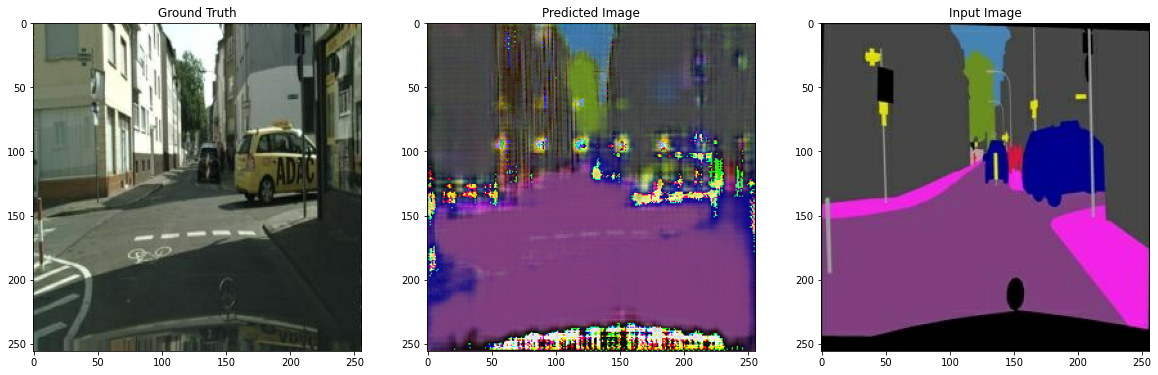

In [30]:
test_generator(1)

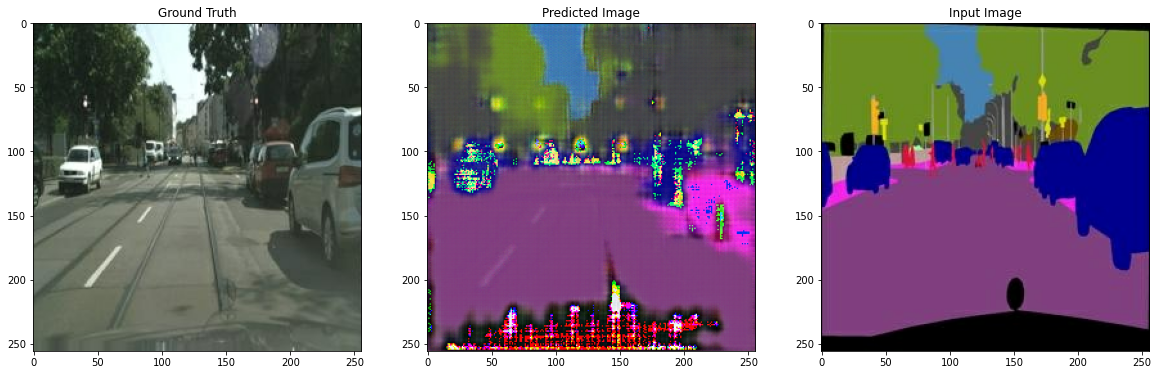

In [31]:
test_generator(2)

### 추가 테스트 결과

- epoch 50회
![ㅇ](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp17/data/50.png?raw=true)

- epoch 100회
![ㅇ](https://github.com/riverlike/Aiffel_Project/blob/main/Exploration/Exp17/data/100.png?raw=true)

# Reference
- [Tensorflow Pix2Pix Tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix?hl=ko)

- https://www.secmem.org/blog/2020/07/19/pix2pix/
